# The flower dataset was downloaded from the link

# Out of the images, 42 daisy images and 28 dandelion images were chosen for training 

# 7 daisy and 8 dandelion images were chosen for testing, due to time constraint and limited computational ability


# Labelme was used to annotate the dataset and the annotation for each file was exported as a json file

#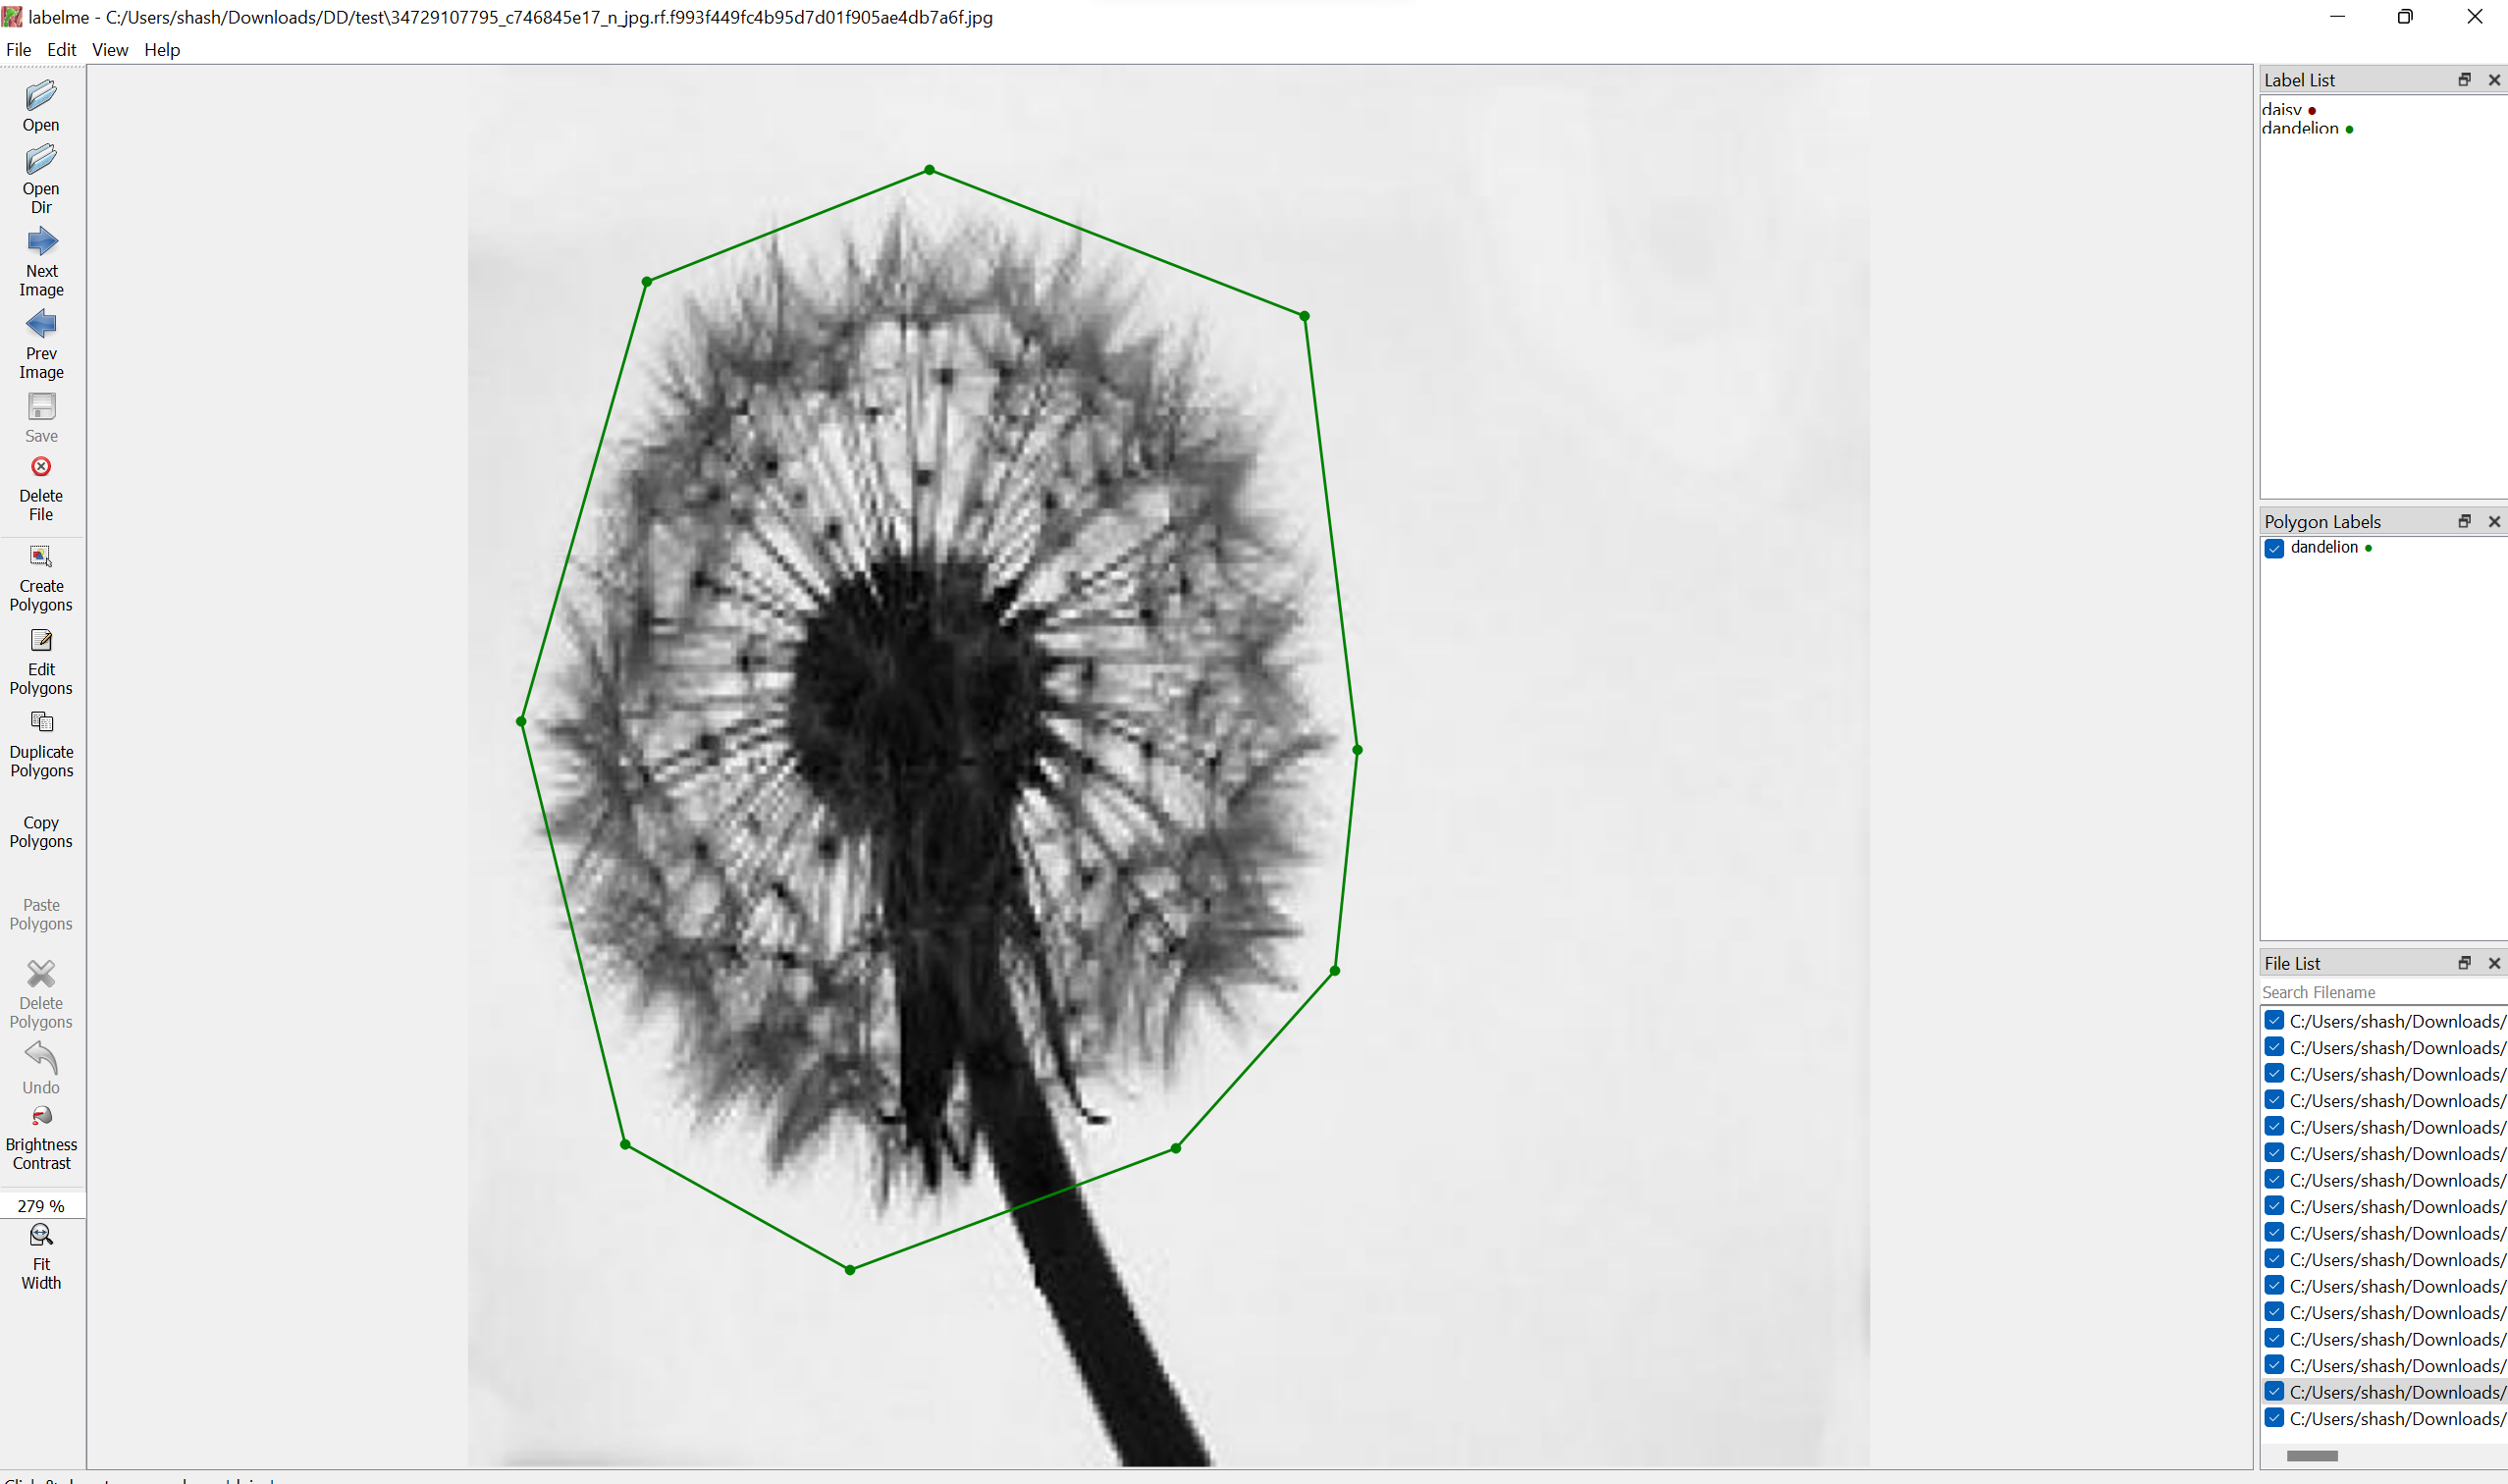

# 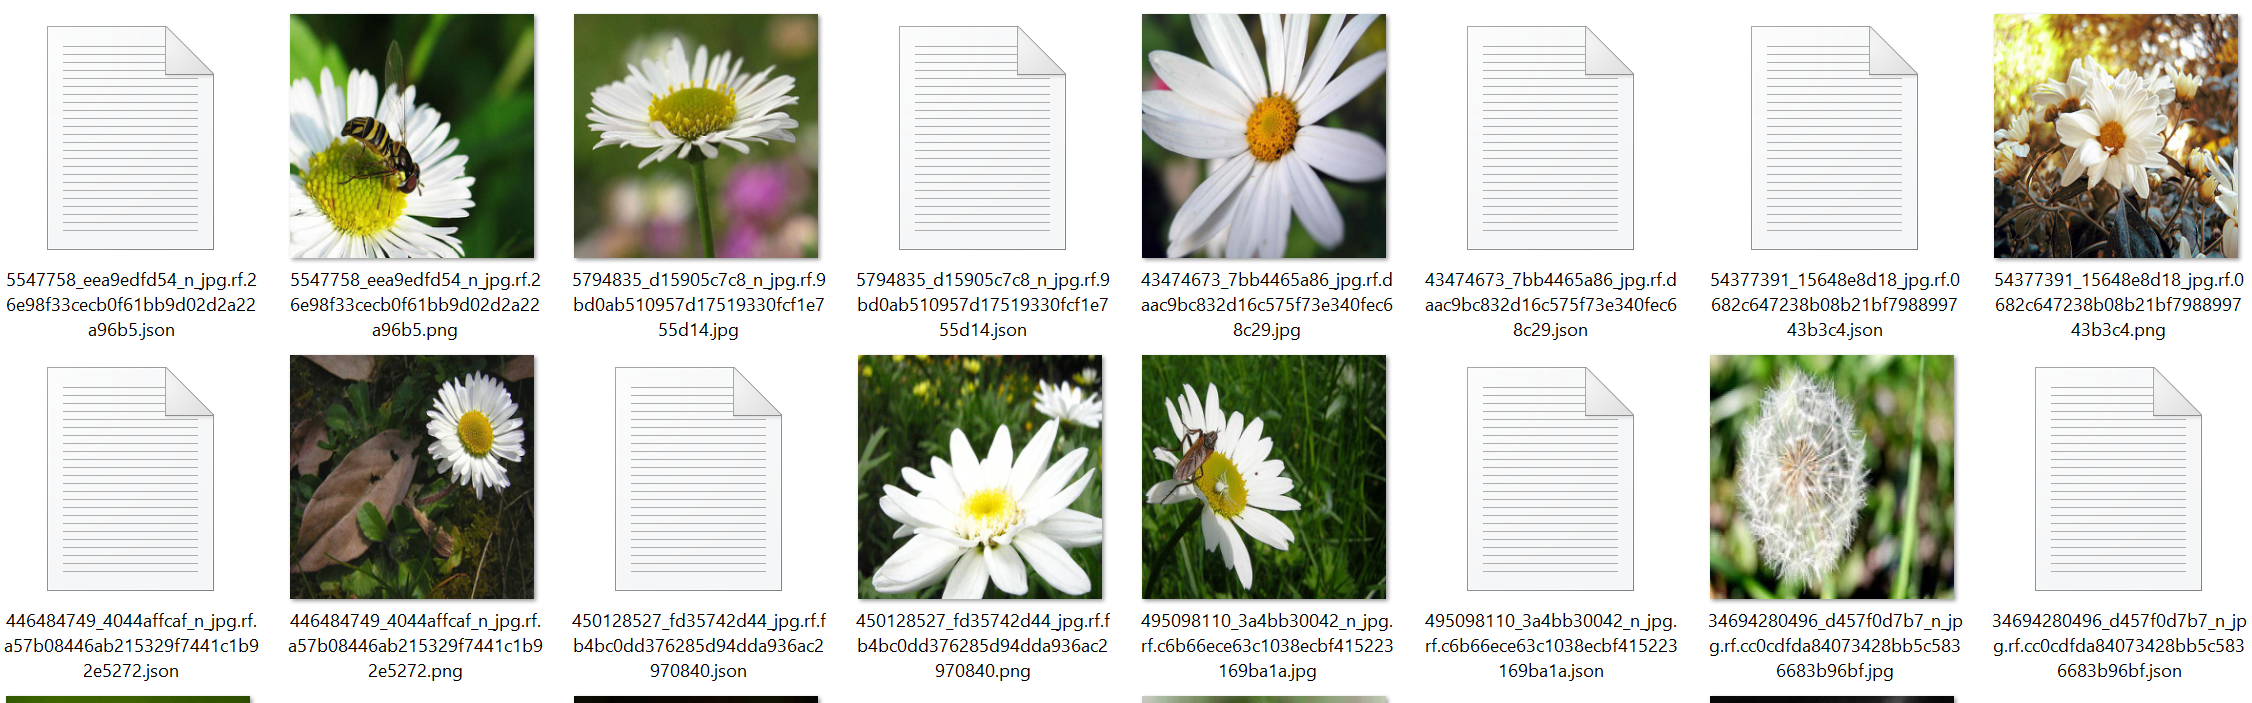

In [1]:

#importing libraries
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import numpy as np
import os, json, cv2, random


from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
import torch
#assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
from detectron2.engine import DefaultTrainer


C:\Users\shash\anaconda3\envs\detect\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##define classes
classes = ['daisy', 'dandelion']

In [3]:
##function for uploading a dataset to detectron2##
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 512
        record["width"] = 512
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
#uploading data
for d in ["train", "test"]:
    DatasetCatalog.register(
        "outlierz" + d, 
        lambda d=d: get_data_dicts(d, classes)
    )
    MetadataCatalog.get("outlierz" + d).set(thing_classes=classes)



In [6]:
#saving metadata
microcontroller_metadata = MetadataCatalog.get("outlierztrain")

In [7]:

cfg = get_cfg()


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("outlierztrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
# Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
# pick a good LR
cfg.SOLVER.MAX_ITER = 300    
# 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        
# do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
# faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
# only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/09 12:23:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/09 12:23:01 d2.data.build]: Removed 0 images with no usable annotations. 69 images left.
[10/09 12:23:01 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   daisy    | 52           | dandelion  | 29           |
|            |              |            |              |
|   total    | 81           |            |              |
[10/09 12:23:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/09 12:23:01 d2.data.build]: Using training sampler TrainingSampler
[10/09 12:23:01 d2.data.common]: Serializing 69 elements to byte tensors and concatenating them all ...
[10/09 12:23:01 d2.data.common]: Serialized dataset takes 0.04 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[10/09 12:23:01 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\shash\anaconda3\envs\detect\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/09 12:23:19 d2.utils.events]:  eta: 0:02:26  iter: 19  total_loss: 2.203  loss_cls: 1.016  loss_box_reg: 0.4728  loss_mask: 0.6943  loss_rpn_cls: 0.002908  loss_rpn_loc: 0.007563  time: 0.5924  data_time: 0.0491  lr: 1.6068e-05  max_mem: 1570M
[10/09 12:23:30 d2.utils.events]:  eta: 0:02:16  iter: 39  total_loss: 1.903  loss_cls: 0.7097  loss_box_reg: 0.4722  loss_mask: 0.6723  loss_rpn_cls: 0.003308  loss_rpn_loc: 0.006597  time: 0.5775  data_time: 0.0496  lr: 3.2718e-05  max_mem: 1657M
[10/09 12:23:41 d2.utils.events]:  eta: 0:02:05  iter: 59  total_loss: 1.53  loss_cls: 0.4615  loss_box_reg: 0.4609  loss_mask: 0.6329  loss_rpn_cls: 0.005835  loss_rpn_loc: 0.005716  time: 0.5588  data_time: 0.0382  lr: 4.9367e-05  max_mem: 1657M
[10/09 12:23:52 d2.utils.events]:  eta: 0:01:56  iter: 79  total_loss: 1.483  loss_cls: 0.3617  loss_box_reg: 0.5195  loss_mask: 0.5873  loss_rpn_cls: 0.003574  loss_rpn_loc: 0.007116  time: 0.5649  data_time: 0.0462  lr: 6.6017e-05  max_mem: 1657M
[10/09

In [8]:
#testing the data
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("outlierstest", )
predictor = DefaultPredictor(cfg)

[10/09 12:26:19 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [10]:
##for test data
test_dataset_dicts = get_data_dicts('test', classes)

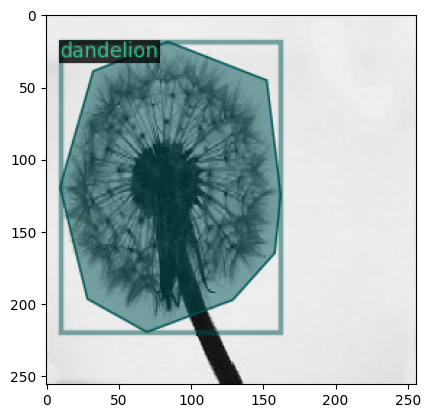

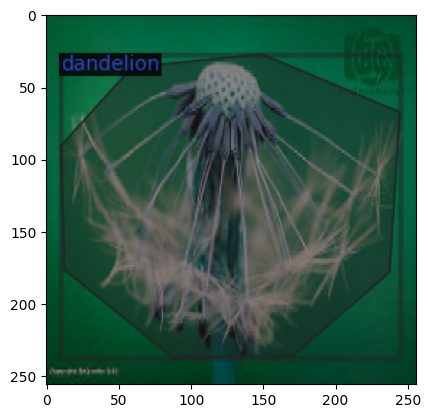

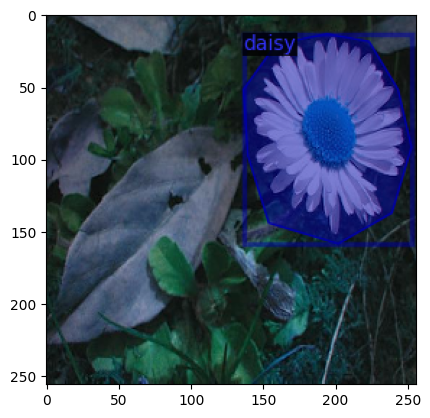

In [11]:
##showing examples of the code on testset##
from matplotlib import pyplot as plt
import cv2

my_dataset_train_metadata = microcontroller_metadata
dataset_dicts = test_dataset_dicts
import random

from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    vis=vis.get_image()[:, :, ::-1]
    #print(vis)
    plt.imshow(vis)
    plt.show()